In [12]:
fasta_path="/kaggle/input/dataset-rna/bpRNA_1m_90.fasta"
dataset_path = "/kaggle/input/dataset-rna/bpRNA_1m_90_dbnFiles/bpRNA_1m_90_DBNFILES"
model_path="/kaggle/working/best_model.pt"

In [13]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [14]:

import os
import torch
import numpy as np
import torch.nn as nn
from Bio import SeqIO
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
# structure_utils

def dot_bracket_to_matrix(dot_bracket):
    L = len(dot_bracket)
    matrix = [[0] * L for _ in range(L)]
    pairs = {'(': ')', '[': ']', '{': '}', '<': '>'}
    stacks = {k: [] for k in pairs}
    for i, sym in enumerate(dot_bracket):
        if sym in stacks:
            stacks[sym].append(i)
        else:
            for op, cl in pairs.items():
                if sym == cl and stacks[op]:
                    j = stacks[op].pop()
                    matrix[i][j] = matrix[j][i] = 1
                    break
    return matrix

def evaluate_base_pair_prediction(true_matrix, pred_matrix, threshold=0.5):
    pred_bin = (pred_matrix > threshold).int().cpu().numpy()
    true_bin = np.array(true_matrix)
    TP = np.sum((pred_bin == 1) & (true_bin == 1))
    FP = np.sum((pred_bin == 1) & (true_bin == 0))
    FN = np.sum((pred_bin == 0) & (true_bin == 1))
    TN = np.sum((pred_bin == 0) & (true_bin == 0))
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-8)
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}


In [16]:
# dataloder.py

class RNADataset(Dataset):
    def __init__(self, fasta_path, dbn_dir, max_len=400, max_samples=10000):
        self.pairs = []
        records = list(SeqIO.parse(fasta_path, "fasta"))
        for record in records:
            rna_id = record.id
            seq = str(record.seq)
            dbn_path = os.path.join(dbn_dir, f"{rna_id}.dbn")
            if not os.path.isfile(dbn_path):
                continue
            with open(dbn_path) as f:
                for line in f:
                    line = line.strip()
                    if set(line).issubset(set("().[]{}<>")):
                        struct = line
                        break
                else:
                    continue
            if len(seq) == len(struct) and len(seq) <= max_len:
                self.pairs.append((seq, struct))
                if max_samples is not None and len(self.pairs) >= max_samples:
                  break


    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seq, struct = self.pairs[idx]
        enc = one_hot_encode_sequence(seq)
        label = dot_bracket_to_matrix(struct)
        return torch.tensor(enc, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

def pad_collate(batch):
    sequences, matrices = zip(*batch)
    lengths = [s.shape[0] for s in sequences]
    max_len = max(lengths)
    padded_seqs = torch.zeros(len(batch), max_len, 4)
    padded_labels = torch.zeros(len(batch), max_len, max_len)
    for i, (seq, mat) in enumerate(zip(sequences, matrices)):
        L = seq.shape[0]
        padded_seqs[i, :L] = seq
        padded_labels[i, :L, :L] = mat
    return padded_seqs, padded_labels, lengths


In [17]:
# model.py

class RNABasePairPredictor(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.bilstm = nn.LSTM(
            input_size=64,
            hidden_size=hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.3)
        self.norm = nn.LayerNorm(2 * hidden_dim)
        self.linear_pairwise = nn.Linear(4 * hidden_dim, 128)
        self.scorer = nn.Sequential(
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x, lengths):
        B, L, _ = x.shape
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.bilstm(self.cnn(x).permute(0, 2, 1))
        x = self.dropout(lstm_out)
        x = self.norm(x)
        i = x.unsqueeze(2).expand(-1, L, L, -1)
        j = x.unsqueeze(1).expand(-1, L, L, -1)
        pair_repr = torch.cat([i, j], dim=-1)
        pair_repr = self.linear_pairwise(pair_repr)
        pair_scores = self.scorer(pair_repr).squeeze(-1)
        return pair_scores


In [18]:
# train

def compute_pos_weight(dataset):
    pos, neg = 0, 0
    for _, label in dataset:
        pos += label.sum().item()
        neg += label.numel() - label.sum().item()
    return neg / (pos + 1e-8)


def train(num_epochs=30, batch_size=8):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = RNADataset(fasta_path, dataset_path, max_len=400, max_samples=10000)
    val_size = int(0.2 * len(dataset))
    train_set, val_set = random_split(dataset, [len(dataset) - val_size, val_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=pad_collate, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=1, collate_fn=pad_collate)

    model = RNABasePairPredictor().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    pos_weight = torch.tensor(compute_pos_weight(train_set), dtype=torch.float32).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_f1 = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_f1s = []
    conf_matrices = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for x, y, lengths in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x, lengths)
            loss = criterion(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()

            pred_label = (torch.sigmoid(pred) > 0.7).float()
            correct += (pred_label == y).sum().item()
            total += y.numel()

        scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)

        print(f"\n📚 Epoch {epoch + 1} — Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

        model.eval()
        all_metrics = []
        total_val_loss = 0
        correct, total = 0, 0
        y_true_all, y_pred_all = [], []

        with torch.no_grad():
            for x, y, lengths in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x, lengths)
                loss = criterion(pred, y)
                total_val_loss += loss.item()

                pred_label = (torch.sigmoid(pred) > 0.7).float()
                correct += (pred_label == y).sum().item()
                total += y.numel()

                y_true_all.extend(y.view(-1).cpu().numpy())
                y_pred_all.extend(pred_label.view(-1).cpu().numpy())

                metrics = evaluate_base_pair_prediction(y[0].cpu(), pred[0].cpu(), threshold=0.7)
                all_metrics.append(metrics)

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = correct / total
        avg = {k: sum(m[k] for m in all_metrics) / len(all_metrics) for k in all_metrics[0]}

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(avg["f1"])

        conf_matrix = confusion_matrix(y_true_all, y_pred_all)
        conf_matrices.append(conf_matrix)

        print(f"🧪 Validation — Precision: {avg['precision']:.4f}, Recall: {avg['recall']:.4f}, F1: {avg['f1']:.4f}, "
              f"Accuracy: {avg['accuracy']:.4f} | Val Accuracy (Raw): {val_acc:.4f}")

        if avg["f1"] > best_f1:
            best_f1 = avg["f1"]
            torch.save(model.state_dict(), model_path)
            print("💾 Model saved with best F1 score!")

    # 📈 Plot Loss, Accuracy, F1
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.plot(val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(val_f1s, label='Val F1', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Validation F1 Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 🧾 Final Confusion Matrix
    final_cm = conf_matrices[-1]
    disp = ConfusionMatrixDisplay(confusion_matrix=final_cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Final Validation Confusion Matrix")
    plt.show()

In [19]:
# encoding_utils

def one_hot_encode_sequence(seq):
    map = {
        'A': [1, 0, 0, 0],
        'U': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'C': [0, 0, 0, 1],
        'N': [0.25, 0.25, 0.25, 0.25]
    }
    return np.array([map.get(base.upper(), map['N']) for base in seq])


In [20]:
def visualize_matrix(matrix, title="Predicted Base Pair Probabilities", cmap="viridis", idx=0):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap=cmap, origin='lower')
    plt.title(f"Sample {idx + 1} — {title}")
    plt.xlabel("Position j")
    plt.ylabel("Position i")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def prob_matrix_to_pseudoknot_dot_bracket(prob_matrix, threshold=0.5):
    L = prob_matrix.shape[0]
    paired = [-1] * L
    pairs = []

    for i in range(L):
        for j in range(i+1, L):
            if prob_matrix[i, j] > threshold:
                pairs.append((i, j, prob_matrix[i, j]))

    pairs.sort(key=lambda x: x[2], reverse=True)

    brackets = ['(', ')', '[', ']', '{', '}', '<', '>']
    bracket_pairs = [(0,1), (2,3), (4,5), (6,7)]
    used_pairs = set()
    bracket_usage = [-1] * L

    structure = ['.'] * L

    def is_crossing(i1, j1, i2, j2):
        return (i1 < i2 < j1 < j2) or (i2 < i1 < j2 < j1)

    for i, j, prob in pairs:
        if paired[i] != -1 or paired[j] != -1:
            continue
        assigned = False
        for b_idx, (open_b, close_b) in enumerate(bracket_pairs):
            conflict = False
            for (pi, pj) in used_pairs:
                if is_crossing(i, j, pi, pj) and b_idx == bracket_usage[pi]:
                    conflict = True
                    break
            if not conflict:
                structure[i] = brackets[open_b]
                structure[j] = brackets[close_b]
                paired[i], paired[j] = j, i
                used_pairs.add((i,j))
                bracket_usage[i] = b_idx
                bracket_usage[j] = b_idx
                assigned = True
                break
        if not assigned:
            structure[i] = '('
            structure[j] = ')'
            paired[i], paired[j] = j, i

    return ''.join(structure)

def export_ct_file(seq, dot_bracket, filepath):
    L = len(seq)
    pair_map = [-1] * L

    bracket_pairs = {'(': ')', '[': ']', '{': '}', '<': '>'}
    stacks = {k: [] for k in bracket_pairs.keys()}

    for i, ch in enumerate(dot_bracket):
        if ch in bracket_pairs:
            stacks[ch].append(i)
        else:
            for open_b, close_b in bracket_pairs.items():
                if ch == close_b:
                    if stacks[open_b]:
                        j = stacks[open_b].pop()
                        pair_map[i] = j + 1
                        pair_map[j] = i + 1

    with open(filepath, 'w') as f:
        f.write(f"{L} RNA secondary structure\n")
        for i in range(L):
            prev_nt = i if i > 0 else 0
            next_nt = i + 2 if i < L - 1 else 0
            paired_nt = pair_map[i] if pair_map[i] != -1 else 0
            f.write(f"{i+1} {seq[i]} {prev_nt} {next_nt} {paired_nt} {i+1}\n")

def evaluate_model(checkpoint_path, test_fasta, test_dbn_dir, max_len=400, num_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RNABasePairPredictor().to(device)
    print("📦 Loading model weights...")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    print("📥 Loading test data...")
    dataset = RNADataset(test_fasta, test_dbn_dir, max_len=max_len, max_samples=num_samples)

    thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    results = {th: {"precision": 0, "recall": 0, "f1": 0, "accuracy": 0} for th in thresholds}

    export_dir = "predictions_ct"
    if not os.path.exists(export_dir):
        os.makedirs(export_dir)

    for idx in range(len(dataset)):
        seq_tensor, label_tensor = dataset[idx]
        input_tensor = seq_tensor.unsqueeze(0).to(device)
        label_matrix = label_tensor.to(device)
        seq_str = ''.join(['A', 'U', 'G', 'C'][np.argmax(seq_tensor.numpy(), axis=1)[i]] for i in range(seq_tensor.shape[0]))

        with torch.no_grad():
            output = model(input_tensor, [seq_tensor.shape[0]])
            output = output[0].cpu()

        for th in thresholds:
            metrics = evaluate_base_pair_prediction(label_matrix.cpu(), output, threshold=th)
            for k in results[th]:
                results[th][k] += metrics[k]

        # Visualize predicted heatmap for threshold 0.7 only (or any you prefer)
        if idx < 5:  # visualize only first few samples
            visualize_matrix(output.numpy(), idx=idx)

        # Convert to pseudoknot dot-bracket with threshold 0.7 for export and printing
        pred_structure = prob_matrix_to_pseudoknot_dot_bracket(output.numpy(), threshold=0.7)
        print(f"\n🔠 Predicted pseudoknot-aware structure (dot-bracket) for Sample {idx + 1}:\n{pred_structure}\n")

        # Export to .ct file for visualization tools
        ct_path = os.path.join(export_dir, f"sample_{idx+1}.ct")
        export_ct_file(seq_str, pred_structure, ct_path)
        print(f"💾 Exported .ct file for Sample {idx + 1} to: {ct_path}")

    # Average metrics and print
    for th in thresholds:
        for k in results[th]:
            results[th][k] /= len(dataset)
        print(f"Threshold {th:.1f} — Precision: {results[th]['precision']:.4f}, Recall: {results[th]['recall']:.4f}, "
              f"F1: {results[th]['f1']:.4f}, Accuracy: {results[th]['accuracy']:.4f}")





📚 Epoch 1 — Train Loss: 0.3081 | Train Accuracy: 0.9723
🧪 Validation — Precision: 0.0382, Recall: 0.8203, F1: 0.0720, Accuracy: 0.8972 | Val Accuracy (Raw): 0.9075
💾 Model saved with best F1 score!

📚 Epoch 2 — Train Loss: 0.2240 | Train Accuracy: 0.9768
🧪 Validation — Precision: 0.0425, Recall: 0.8571, F1: 0.0798, Accuracy: 0.9036 | Val Accuracy (Raw): 0.9128
💾 Model saved with best F1 score!

📚 Epoch 3 — Train Loss: 0.2045 | Train Accuracy: 0.9800
🧪 Validation — Precision: 0.0457, Recall: 0.8514, F1: 0.0852, Accuracy: 0.9100 | Val Accuracy (Raw): 0.9227
💾 Model saved with best F1 score!

📚 Epoch 4 — Train Loss: 0.1866 | Train Accuracy: 0.9821
🧪 Validation — Precision: 0.0610, Recall: 0.8472, F1: 0.1115, Accuracy: 0.9334 | Val Accuracy (Raw): 0.9388
💾 Model saved with best F1 score!

📚 Epoch 5 — Train Loss: 0.1801 | Train Accuracy: 0.9828
🧪 Validation — Precision: 0.0566, Recall: 0.8753, F1: 0.1039, Accuracy: 0.9219 | Val Accuracy (Raw): 0.9283

📚 Epoch 6 — Train Loss: 0.1658 | Train

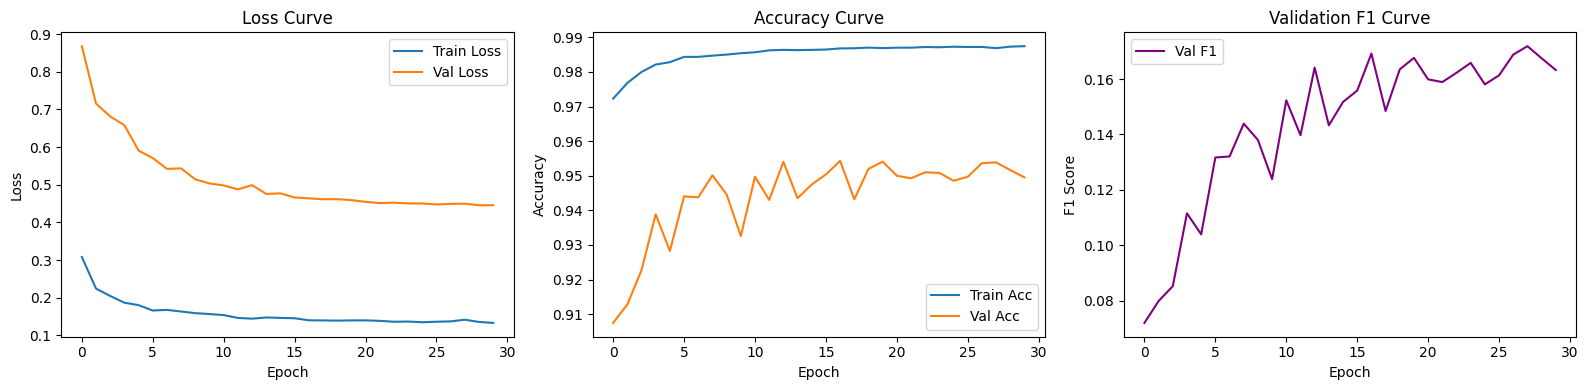

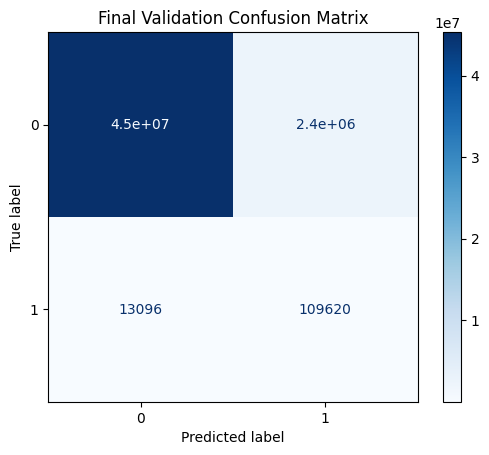

In [21]:
train()

📦 Loading model weights...
📥 Loading test data...


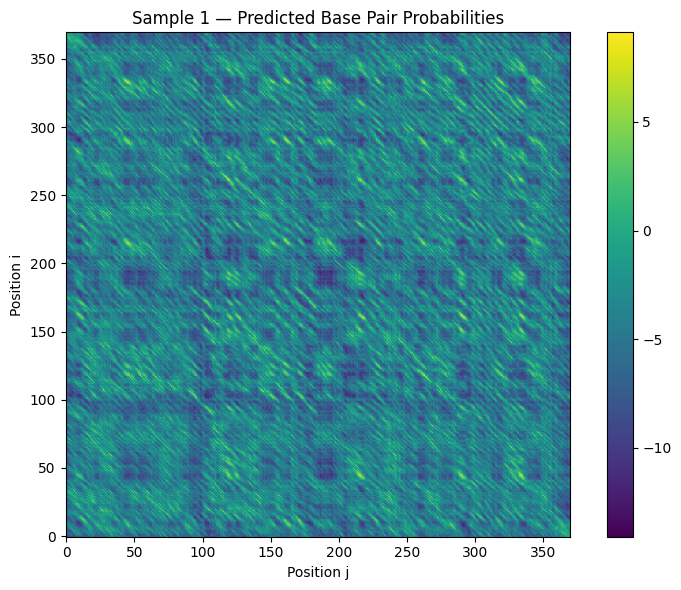


🔠 Predicted pseudoknot-aware structure (dot-bracket) for Sample 1:
((((((<<<<(((((([[{(([.[(())<<(([()<((((((..<<<<<]({({.((..)((<(<(](]((<)]][[([(()(.]{]{{(.((<<<.(.).<[[[)[[)<)<.){{((((((){{{{(()(((())()))))(]](({{]]](({>(>))([[)[(()(())}>(())>>>))[......)(.(..((>()))).)>)}})>>>>>>)((>((()])}}}}(((()>>())())(.)((.([[[))))[[))))(}}()))})())((..)>>>>))))))<]]))))]]](]}[}))((())))<)])[)})}})))))>(]]]()).))>)))).]))((()))...)..))...)..

💾 Exported .ct file for Sample 1 to: predictions_ct/sample_1.ct


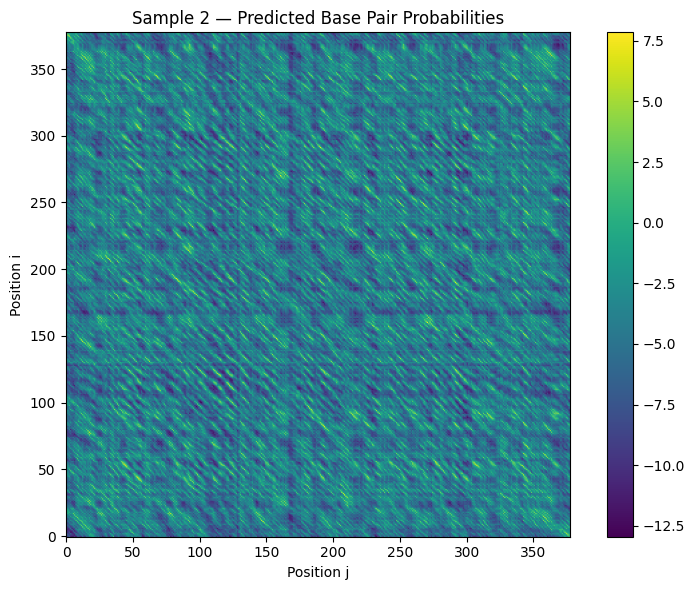


🔠 Predicted pseudoknot-aware structure (dot-bracket) for Sample 2:
.(((({([((({{{)[{{{[((.{(.(()[{[[[([))(([.(((((<(]](<)))<<}(((().[(..<<(.)}..}}}(][[[(((((((((([[[)((((....()>>[(((]...({))))))(..<([[)}[(((..).(}}}((({(>])))((()<<<)..(.(()))(<<]])]]]...{.{{]]]()(.).)){{{{]]](]((()).)(...)))){{))))){..[))>>)[.[)((((((]}(....}}..).))))))>>>)>>)..}}}}.....)(}}[}.))((([[)))))>))))).)]]))..))((((()))))](((...>)})]))])).].(.)]))(())......)}.)))].

💾 Exported .ct file for Sample 2 to: predictions_ct/sample_2.ct


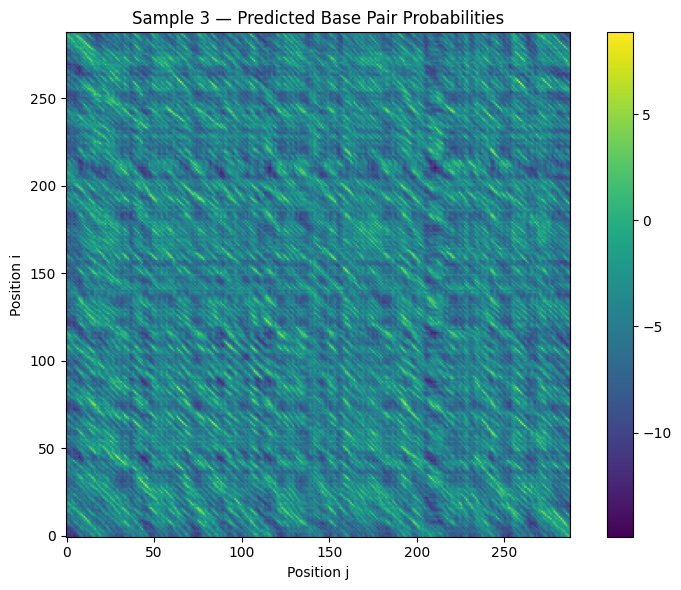


🔠 Predicted pseudoknot-aware structure (dot-bracket) for Sample 3:
..(...{<<(((((({{((<<((({([[((((([[[..()<()))))}[{[[(...()[[.)(((((((}(((.(}}(}(.))))({{({(((.(.>>>......(()[))...((([[(.)))().(((.(]].....{[[(((.(.]])](((..}))]]<)}){..((.)]]))()().(......)({))])>)>>})})..]]]))[[[[..)(((...]..))<]]])}}.(){())))()).....).))(())))]]).)>)))}).)).))))))))).

💾 Exported .ct file for Sample 3 to: predictions_ct/sample_3.ct


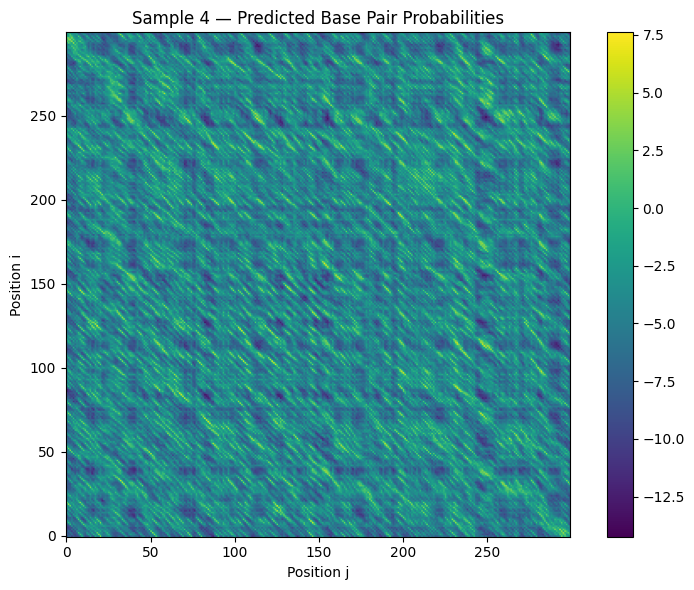


🔠 Predicted pseudoknot-aware structure (dot-bracket) for Sample 4:
{([(((.((((...[(((((}(..((({(]((())(....(..(..((<()](((((({(<<(((((((((({{.....[<)))))){{{{....)){{{[)(((((}(((([[.[{(.))))))))([[[[.)())..>.({))))(]]..)(((<<<.))))))..()]}()....<)))<((}..)))((..))))}}<)]))..(())}})(())...(.....)((]}})>))()))>>.)}}]][(().>>>..).]}}.>>>)).))).{{.)])))()...)...)))]}}.

💾 Exported .ct file for Sample 4 to: predictions_ct/sample_4.ct


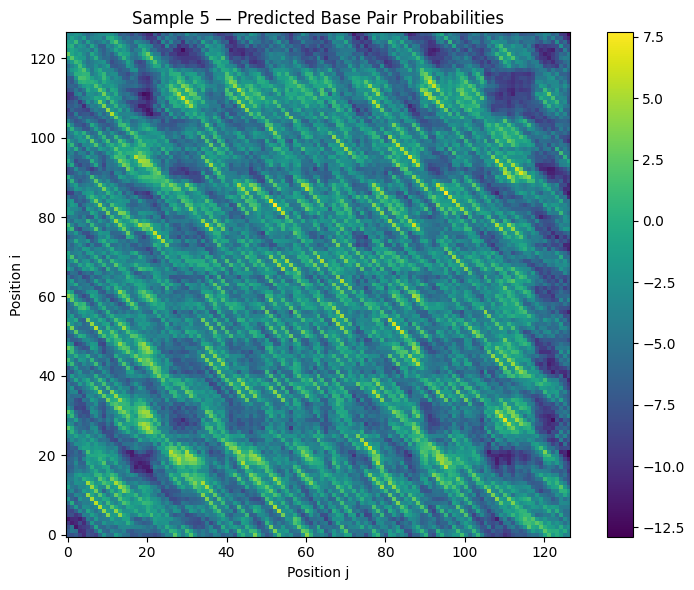


🔠 Predicted pseudoknot-aware structure (dot-bracket) for Sample 5:
<<<(<((())){{{<<((<((([[[[))(((...}}{{(()).(>(>>)((((((([>>>><(}(..<])<).]]]]}[))))))((]([[[[)[))>..>).).)})]))))]]>]])........

💾 Exported .ct file for Sample 5 to: predictions_ct/sample_5.ct
Threshold 0.5 — Precision: 0.0237, Recall: 0.8700, F1: 0.0462, Accuracy: 0.9372
Threshold 0.6 — Precision: 0.0249, Recall: 0.8667, F1: 0.0485, Accuracy: 0.9405
Threshold 0.7 — Precision: 0.0262, Recall: 0.8591, F1: 0.0507, Accuracy: 0.9438
Threshold 0.8 — Precision: 0.0274, Recall: 0.8546, F1: 0.0532, Accuracy: 0.9467
Threshold 0.9 — Precision: 0.0287, Recall: 0.8462, F1: 0.0554, Accuracy: 0.9495


In [22]:
evaluate_model(model_path, fasta_path, dataset_path)

In [23]:
import torch
import numpy as np
import urllib.parse

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RNABasePairPredictor().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

dataset = RNADataset(fasta_path, dataset_path, max_len=400, max_samples=5)

def get_forna_url(dot_bracket, sequence):
    encoded_seq = urllib.parse.quote(sequence)
    encoded_struct = urllib.parse.quote(dot_bracket)
    return f"http://rna.tbi.univie.ac.at/forna/forna.html?seq={encoded_seq}&str={encoded_struct}"

for idx in range(len(dataset)):
    seq_tensor, label_tensor = dataset[idx]
    input_tensor = seq_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor, [seq_tensor.shape[0]])
    output_np = output[0].cpu().numpy()

    pred_structure = prob_matrix_to_pseudoknot_dot_bracket(output_np, threshold=0.7)
    seq_str = ''.join([['A', 'U', 'G', 'C'][np.argmax(row)] for row in seq_tensor.numpy()])

    forna_url = get_forna_url(pred_structure, seq_str)

    print(f"Sample {idx + 1}")
    print(f"Sequence: {seq_str}")
    print(f"Predicted Structure: {pred_structure}")
    print(f"Visualize on forna: {forna_url}")
    print("\nIf the link doesn’t open directly, copy-paste the sequence and structure on the forna web page.\n")


Sample 1
Sequence: UGACAUGCUCCCUGGGCUGCGGAGACGUGCGUGCAUUUGGUUGGGGGUGUGCAGGUGGUGCAUGGUUGUCGUCAGCUCGUGUCGUGAGAUGUUGGGUUAAGUCCCGCAACGAGCGCAACCCUUGCCCUAUGUUGCCAGCACGUUGUGGUGGGGACUCGUAGGGGACUGCCGGGGUUAACUCGGAGGAAGGUGGGGAUGACGUCAAAUCAUCAUGCCCCUUAUGUCUUGGGCUUCACGCAUGCUACAAUGGUUGGUACAGAGGGUUGCGAUAUCGUGAGGUGGAGCGAAUCCCUUAAAGCCAGUCUCAGUUCGGAUUGGGGUCUGCAACUCGACCCCAUGAAGGUGGAGUCGCUAGUAAUCGAAGAUAAGA
Predicted Structure: ((((((<<<<(((((([[{(([.[(())<<(([()<((((((..<<<<<]({({.((..)((<(<(](]((<)]][[([(()(.]{]{{(.((<<<.(.).<[[[)[[)<)<.){{((((((){{{{(()(((())()))))(]](({{]]](({>(>))([[)[(()(())}>(())>>>))[......)(.(..((>()))).)>)}})>>>>>>)((>((()])}}}}(((()>>())())(.)((.([[[))))[[))))(}}()))})())((..)>>>>))))))<]]))))]]](]}[}))((())))<)])[)})}})))))>(]]]()).))>)))).]))((()))...)..))...)..
Visualize on forna: http://rna.tbi.univie.ac.at/forna/forna.html?seq=UGACAUGCUCCCUGGGCUGCGGAGACGUGCGUGCAUUUGGUUGGGGGUGUGCAGGUGGUGCAUGGUUGUCGUCAGCUCGUGUCGUGAGAUGUUGGGUUAAGUCCCGCAACGAGCGCAACCCUUGCCCUAUGUUGCCAGCACGUUGUGGU